In [33]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [10]:
img = cv2.imread('../static/test3.jpg')

In [24]:
def gaussian_pyramid(img, sigma=8):
    """compute gaussian pyramid representation of image
    
    Parameters
    ----------
    img : numpy.ndarray
        image, loaded using cv2.
    sigma : int
        number of levels in gaussian pyramid.
        Default is 8, the number used in Itti Koch Nieber.
        Level zero is the original image,
        levels 1 through sigma are the subsampled and smoothed of the level below them.
    
    Returns
    -------
    img_out : list
        of numpy.ndarrays, with sigma + 1 elements.
    """
    img_out = [img]
    for i in range(sigma):
        img_out.append(cv2.pyrDown(img_out[i]))
    return img_out

In [60]:
def center_surround(pyramid_c, pyramid_s=None, c_range=(2,3,4), delta_range=(3,4)):
    """compute center-surround difference from a gaussian pyramid
    and return feature maps
    
    Parameters
    ----------
    pyramid_c : list
        of numpy.ndarray, returned by gaussian_pyramid.
        Centers of receptive fields are taken from levels of this pyramid.
    pyramid_s : list
        of numpy.ndarray, returned by gaussian_pyramid.
        Surrounds of receptive fields are taken from levels of this pyramid.
        Default is None, in which case pyramid_c is used.
    c_range : tuple, list
        of int, indices of levels of pyramid to use as "centers".
        Default is (2, 3, 4), levels used in Itti Koch Niebur.
    delta_range : tuple, list
        of int, indices of levels of pyramid to use as "surrounds".
        Default is (3, 4), levels used in Itti Koch Niebur.

    Returns
    -------
    maps
    """
    if pyramid_s is None:
        pyramid_s = pyramid_c

    maps = []
    for delta in delta_range:
        for c in c_range:
            center = pyramid_c[c]
            surround = pyramid_s[c + delta]
            surround = cv2.resize(surround, center.shape[:2],
                                  interpolation=cv2.INTER_LINEAR)
            maps.append(cv2.absdiff(center, surround))
    return maps

In [25]:
pyramid = gaussian_pyramid(img)

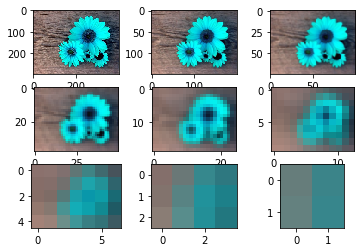

In [29]:
fig, ax = plt.subplots(3, 3)
ax = ax.ravel()
for ind, level in enumerate(pyramid):
    ax[ind].imshow(level)

In [57]:
def get_channels(img):
    """take RGB image and convert to 
    red, green, blue, yellow and intensity channels
    used by Itti Koch Niebur model
    
    Parameters
    ----------
    img : numpy.ndarray
        returned by cv2.imread
    
    Returns
    -------
    R, G, B, Y, I : numpy.ndarray
        calculated as described in Itti Koch Niebur
    """
    b, g, r = cv2.split(img)
    I = (b + g + r) / 3

    # normalize r g b by I
    # to "decouple hue from intensity"
    # only do so at locations where intensity is greater than 1/10 of its maximum
    I_norml = np.where(I > 0.1 * I.max(), I, 1)
    b = b / I_norml
    g = g / I_norml
    r = r / I_norml
    
    R = r - (g + b) / 2
    G = g - (r + b) / 2
    B = b - (r + g) / 2
    Y = (r + g) / 2 - np.abs(r - g) / 2 - b
    colors = [R, G, B, Y]
    # negative values are set to zero
    (R, G, B, Y) = map(lambda arr: np.where(arr >= 0, arr, 0), 
                       colors)

    return R, G, B, Y, I

In [58]:
def _feature_maps(channel, sigma=8, c_range=(2, 3, 4), delta_range=(3, 4)):
    """helper function to compute feature maps, given a channel
    Parameters
    ----------
    channel : numpy.ndarray
        channel, either returned by get_channels or derived from 
        one of those channels (e.g. the inverse of intensity I)
    sigma : int
        parameter for gaussian_pyramid function, number of levels.
        Default is 8.
    c_range : list, tuple
        of int. Parameter for center_surround function, levels to use
        as centers. 
        Default is (2, 3, 4)
    delta_range : list, tuple
        of int. Parameter for center_surround function, used to find
        surround levels s. For each center c there will be a surround s 
        which is (c + delta).
        Default is (3, 4)

    Returns
    -------
    maps : list
        of numpy.ndarray, maps computed by extracting gaussian pyramid
        and then taking center surround differences
    """
    pyr = gaussian_pyramid(channel, sigma=sigma)
    return center_surround(pyr, c_range=c_range, delta_range=delta_range)


In [59]:
def intensity_ftr_maps(I, sigma=8, c_range=(2, 3, 4), delta_range=(3, 4)):
    """compute intensity feature maps, given intensity channel
    
    Parameters
    ----------
    I : numpy.ndarray
        intensity channel, returned by get_channels
    sigma : int
        parameter for gaussian_pyramid function, number of levels.
        Default is 8.
    c_range : list, tuple
        of int. Parameter for center_surround function, levels to use
        as centers. 
        Default is (2, 3, 4)
    delta_range : list, tuple
        of int. Parameter for center_surround function, used to find
        surround levels s. For each center c there will be a surround s 
        which is (c + delta).
        Default is (3, 4)

    Returns
    -------
    maps : list
        of numpy.ndarray, maps computed by extracting gaussian pyramid
    """
    maps = []
    maps.extend(
        _feature_maps(I, c_range=c_range, delta_range=delta_range)
    )
    
    I_inverse = cv2.bitwise_not(I)
    maps.extend(
        center_surround(I_inverse, c_range=c_range, delta_range=delta_range)
    )

    return maps

In [ ]:
def color_ftr_maps(R, G, B, Y,
                   sigma=8, c_range=(2, 3, 4), delta_range=(3, 4)):
    """compute color feature maps, given color channels
    
    Parameters
    ----------
    R, G, B, Y : numpy.ndarray
        color channels, returned by get_channels
    sigma : int
        parameter for gaussian_pyramid function, number of levels.
        Default is 8.
    c_range : list, tuple
        of int. Parameter for center_surround function, levels to use
        as centers. 
        Default is (2, 3, 4)
    delta_range : list, tuple
        of int. Parameter for center_surround function, used to find
        surround levels s. For each center c there will be a surround s 
        which is (c + delta).
        Default is (3, 4)

    Returns
    -------
    maps : list
        of numpy.ndarray, maps computed by extracting gaussian pyramid
    """
    maps = []
    maps.extend(
        _feature_maps(I, c_range=c_range, delta_range=delta_range)
    )
    
    I_inverse = cv2.bitwise_not(I)
    maps.extend(
        center_surround(I_inverse, c_range=c_range, delta_range=delta_range)
    )

    return maps

In [54]:
R, G, B, Y, I = get_channels(img)

In [56]:
R.min()

0.0